# Replication results variational fair autoencoder

This colab notebook gives the replication results for the vfae. Results are presented for the adult data set.
In the paper, Louizos et. al. do report results on a test set, after models were trained on a training set and selected (but not retrained) on a validation set. They do not describe how performance on the validation set was computed, merely stating that the primary aim was fairness, but predictions should not be degenerate. This is a problem for replication, as such a criterion of performance is necessary for model selection. Instead of selecting models on validation data, for this reproduction 20 models are trained on a train set and their performance on the validation related to the test set. If good models that would be selected on training data achieve comparable performance as the performance reported by Louizos et. al. on test data, then their findings could be replicated as close as possible.

## Data preparation

See http://www.cs.toronto.edu/~zemel/documents/fair-icml-supp-final.pdf for the details (Louizos et. al. based their data preparation on this paper). Quantitative data is quantilized as per the link. 

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True)
% cd gdrive/My Drive/Masterarbeit

import preprocess 
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
import matplotlib.pyplot as plt
import sklearn 
import torch
import torch.nn as nn
import torch.utils.data
import pickle
import warnings
from sklearn.linear_model import LogisticRegression

warnings.simplefilter(action='ignore', category=FutureWarning)

def quantilize(column):
  quantile_list = [0,]
  quantiles = [0.2,0.4,0.6, 0.8]
  for quant in quantiles:
    quantile_list.append(column.quantile(quantiles)[quant])
  quantile_list.append(np.max(column))
  column = pd.cut(column, bins=quantile_list, right = False, duplicates = 'drop')
  return(column)


adult = pd.read_csv('Dataset.data', delimiter = ' ', header = None)
adult = adult.replace('?', np.nan)
adult = adult.dropna()
adult.columns = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
                  "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

adult["Income"] = adult["Income"].map({ "<=50K": 0, ">50K": 1 })
labels = adult["Income"].values
vars_to_drop = ["Income"]
adult.drop(vars_to_drop, axis=1, inplace=True,)
numvars = ['fnlwgt', 'CapitalLoss', 'Age', 'CapitalGain', 'EducationNum', 'HoursPerWeek']
adult[numvars] = adult[numvars].apply(lambda x: x.astype(float))

for numvar in numvars:
  adult[numvar] = quantilize(adult[numvar])
adult = pd.get_dummies(adult, drop_first = True, columns = adult.columns)
colnames = adult.columns 
adult = pd.DataFrame(adult, columns = colnames)
adult['label'] = labels
adult.name = 'adult'


class dataset_for_preprocessed(torch.utils.data.Dataset):
  def __init__(self, data_set, sensitive_variable):
    self.tensor_data = torch.from_numpy(data_set.values.astype(np.float32))
    self.sensitive_variable = sensitive_variable
  def __len__(self):
    return len(self.tensor_data)

  def __getitem__(self, idx):
    feature_cols       = [x for x in range(self.tensor_data.size()[1]) if x != self.tensor_data.size()[1]-1 and  x!= self.sensitive_variable]
    features           = self.tensor_data[idx, feature_cols]
    sensitive_variable = self.tensor_data[idx, self.sensitive_variable]
    labels             = self.tensor_data[idx, -1]
    return features, sensitive_variable, labels



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/Masterarbeit


## Model definition

Code for MMD is taken from here: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/. This is a full mmd and not just an approximation. The class dist defines the function going from hidden random variable to hidden random variable.

In [0]:

class dist(nn.Module):
  def __init__(self, in_dim, hidden, z):
    super(dist, self).__init__()
    self.hidden = nn.Sequential(nn.Linear(in_dim, hidden),
                                nn.ReLU())
  
    
    self.mu_l     = nn.Linear(hidden, z)
    self.logsigma_l = nn.Linear(hidden, z)

                                  
  def forward(self, inputs):
    hidden = self.hidden(inputs)


    
    mu     = self.mu_l(hidden)
    logsigma  = self.logsigma_l(hidden)
    return(mu, logsigma)
  
  
def reparameterize(mu, logsigma):
  eps              = torch.empty_like(logsigma).normal_() 
  eps              = eps.mul((logsigma*0.5)).exp().add(mu)
  return(eps)  



class vfae(nn.Module):
  def __init__(self, d_x, hidden, z):
    super(vfae, self).__init__()
    self.q_z_1   = dist(d_x+1, hidden, z)
    self.q_y     = nn.Sequential(nn.Linear(z, 1),
                                 nn.Sigmoid())
    self.q_z_2   = dist(z+1, hidden, z)
    self.p_z_1   = dist(z+1, hidden, z)
    self.p_x     = nn.Sequential(nn.Linear(z +1, hidden),
                                 nn.ReLU(),
                                 nn.Linear(hidden, d_x),
                                 nn.Sigmoid())


  def forward(self, x,s,y):
    if self.training:
      mu_q_z_1, logsigma_q_z_1 = self.q_z_1(torch.cat((x,s.unsqueeze(1)),1))
      q_z_1_sample  = reparameterize(mu_q_z_1, logsigma_q_z_1)
      y_recon       = self.q_y(q_z_1_sample)                             
      mu_q_z_2, logsigma_q_z_2 =self.q_z_2(torch.cat((q_z_1_sample,y_recon),1))
      q_z_2_sample  = reparameterize(mu_q_z_2, logsigma_q_z_2)
      mu_p_z_1, logsigma_p_z_1 = self.p_z_1(torch.cat((q_z_2_sample,y),1))
      p_z_1_sample  = reparameterize(mu_p_z_1, logsigma_p_z_1)
      x_recon       = self.p_x(torch.cat((p_z_1_sample,s.unsqueeze(1)),1))

      return({'mu_q_z_1': mu_q_z_1, 'logsigma_q_z_1': logsigma_q_z_1, 'y_recon': y_recon, 'mu_q_z_2': mu_q_z_2 , 'logsigma_q_z_2': logsigma_q_z_2, 
            'mu_p_z_1':mu_p_z_1, 'logsigma_p_z_1': logsigma_p_z_1, 'x_recon': x_recon, 'q_z_1_sample': q_z_1_sample})  
    else:
      mu_q_z_1, logsigma_q_z_1 = self.q_z_1(torch.cat((x,s.unsqueeze(1)),1))
      q_z_1_sample  = reparameterize(mu_q_z_1, logsigma_q_z_1)
      y_recon       = self.q_y(q_z_1_sample)
      return y_recon, q_z_1_sample

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd
  
def dkl_1_2(mu_1, sigma_1, mu_2, sigma_2):
  return(1/2 * (torch.sum(sigma_2.log(), dim=0) - torch.sum(sigma_1.log(), dim = 0) - mu_1.size(0) + torch.sum((sigma_1/sigma_2), dim = 0) + torch.sum(((mu_1 - mu_2)**2 / sigma_2), dim = 0)))



    
def loss_function(x_recon, y_recon, mu_q_z_1, logsigma_q_z_1, mu_q_z_2, logsigma_q_z_2, mu_p_z_1, logsigma_p_z_1, x, y, s0, s1, l1_penalty, l2_penalty, mmd_penalty, variational_alpha = 1, **kwargs):  
  recon_loss_x = nn.BCELoss(reduction = 'sum')(x_recon, x) 
  kldivergence_l_2 = dkl_1_2(mu_q_z_2, logsigma_q_z_2.exp(), torch.zeros(mu_q_z_2.size(0), mu_q_z_2.size(1)).cuda(), torch.ones(mu_q_z_2.size(0), mu_q_z_2.size(1)).cuda()).sum()
  kldivergence_l_1 = dkl_1_2(mu_q_z_1, logsigma_q_z_1.exp(), mu_p_z_1, logsigma_p_z_1.exp()).sum()
  mmd = compute_mmd(s0, s1)    
  recon_loss_y = nn.BCELoss(reduction = 'sum')(y_recon, y)
  return  1 * recon_loss_x +  recon_loss_y  + kldivergence_l_1 +  kldivergence_l_2 + mmd_penalty * mmd

 

## Training and Results

The models are trained for different data set splits and results are reported on the validation set and test set. To keep results comparable to Louizos et. al., train, validation and test data are of the same size as in their paper. Results are comparable to what is reported by Louizos et. al.

In [0]:
results_dic = {}

for i in range(20):
  batch_size  = 100
  weight      = np.asscalar(np.random.uniform(7000,20000, 1))
  lr          = np.asscalar(np.random.uniform(0.004, 0.009, 1))


  data_set = adult
  data_set_size = adult.shape[1]
  data_set_len = adult.shape[0]
  sensitive_variable = adult.columns.get_loc('Gender_Male')
  data_set = data_set.sample(frac=1, random_state = i)
  data_set_train = dataset_for_preprocessed(data_set.iloc[:22000,:], sensitive_variable)  
  data_set_train = dataset_for_preprocessed(data_set.iloc[22000:33000,:], sensitive_variable)  
  data_set_test  = dataset_for_preprocessed(data_set.iloc[33000:,:], sensitive_variable)  
  dataloader_train          = torch.utils.data.DataLoader(data_set_train, batch_size = batch_size, shuffle = True)
  dataloader_train_complete = torch.utils.data.DataLoader(data_set_train, batch_size = 22000, shuffle = False)
  dataloader_validate       = torch.utils.data.DataLoader(data_set_train, batch_size = 11000, shuffle = False)
  dataloader_test           = torch.utils.data.DataLoader(data_set_test, batch_size = adult.shape[0]-33000, shuffle = False)

  model = vfae(data_set_size-2, 100, 50).cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  for epoch in range(15):
    for batch in dataloader_train:

      X, s, y = batch
      X, s, y = X.cuda(), s.cuda(), y.cuda()
      returns =     model(X,s,y.unsqueeze(1))
      loss    = loss_function(x = X, y= y, s0 = returns['q_z_1_sample'][s==0], s1 = returns['q_z_1_sample'][s==1], l1_penalty = 1, l2_penalty = 1, mmd_penalty = weight  * batch_size, variational_alpha = 1, **returns)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  model.eval()
  batch = next(iter(dataloader_train_complete))
  X_train, s_train, y_train = batch
  X_train, s_train, y_train= X_train.cuda(), s_train.cuda(), y_train.cuda()
  y, z_1_train = model(X_train,s_train,y_train)
  batch = next(iter(dataloader_test))
  
  batch = next(iter(dataloader_validate))
  X_validate, s_validate, y_validate = batch
  X_validate, s_validate, y_validate= X_validate.cuda(), s_validate.cuda(), y_validate.cuda()
  y_recon_validate, z_1_validate = model(X_validate,s_validate,y_validate)
  
  accuracy_validate = (((y_recon_validate.squeeze()>0.5).int() == y_validate.int()).sum().float()/len(X_validate)).detach().cpu().numpy()

  fairness_validate = (-(y_recon_validate[s_validate==0]>0.5).sum().float()/len(y_recon_validate[s_validate==0]) + (y_recon_validate[s_validate==1]>0.5).sum().float()/len(y_recon_validate[s_validate==1])).detach().cpu().numpy()
  
  batch = next(iter(dataloader_test))
  
  X_test, s_test, y_test = batch
  X_test, s_test, y_test = X_test.cuda(), s_test.cuda(), y_test.cuda()
  y_recon_test, z_1_test = model(X_test,s_test,y_test)

  accuracy_test = (((y_recon_test.squeeze()>0.5).int() == y_test.int()).sum().float()/len(X_test)).detach().cpu().numpy()

  fairness_test = (-(y_recon_test[s_test==0]>0.5).sum().float()/len(y_recon_test[s_test==0]) + (y_recon_test[s_test==1]>0.5).sum().float()/len(y_recon_test[s_test==1])).detach().cpu().numpy()
  
  logistic_s_z = (LogisticRegression().fit(z_1_train.detach().cpu().numpy(), s_train.detach().cpu().numpy()).predict(z_1_test.detach().cpu().numpy())== s_test.detach().cpu().numpy()).sum()/len(X_test)
 
  results_dic[i] = {'accuracy_validate': accuracy_validate, 'fairness_validate': fairness_validate, 'accuracy_test': accuracy_test, 'fairness_test': fairness_test, 'logistic_s_vae': logistic_s_z}

  print(results_dic)
  
torch.save('results_dic', 'replication_vfae.tar')

  

Text(0.5, 1.0, 'validate')

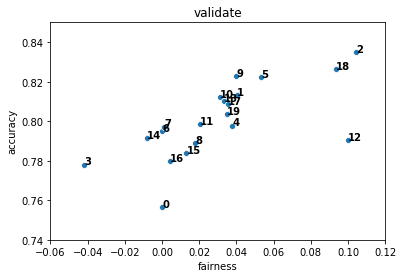

In [0]:
import seaborn as sns
validate = pd.DataFrame.from_dict({key: {'accuracy' : results_dic[key]['accuracy_validate'], 'fairness' : results_dic[key]['fairness_validate'], 'index': key} for key in results_dic.keys()}, orient = 'index')
plot = sns.scatterplot(validate.fairness, validate.accuracy)

for line in range(20):
     plot.text(validate.fairness[line], validate.accuracy[line], 
     validate.index[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')
plot.set(xlim = (-0.06, 0.12), ylim = (0.74, 0.85))
plot.set_title('validate')

Text(0.5, 1.0, 'test')

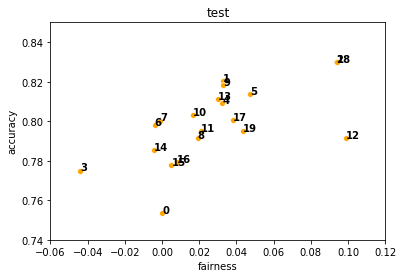

In [0]:
test = pd.DataFrame.from_dict({key: {'accuracy' : results_dic[key]['accuracy_test'], 'fairness' : results_dic[key]['fairness_test'], 'index': key} for key in results_dic.keys()}, orient = 'index')
plot = sns.scatterplot(test.fairness, test.accuracy, color = 'orange')

for line in range(20):
     plot.text(test.fairness[line], test.accuracy[line], 
     test.index[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')
plot.set(xlim = (-0.06, 0.12), ylim = (0.74, 0.85))
plot.set_title('test')